### Кейс 2 - определение ССЗ

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [142]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import seaborn as sns
import itertools
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
import itertools
from sklearn.metrics import roc_auc_score, log_loss

In [143]:
def load_data():
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GB/Machine-learning-in-business/lesson_3/train_case2.csv', ';')
  return df

def get_train_test(df):
  X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                      df['cardio'], random_state=0)
  return X_train, X_test, y_train, y_test


К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [144]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [145]:
def get_transformers():
  continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
  cat_cols = ['gender', 'cholesterol', 'gluc']
  base_cols = ['smoke', 'alco', 'active']

  continuos_transformers = []
  cat_transformers = []
  base_transformers = []

  for cont_col in continuos_cols:
      transfomer =  Pipeline([
                  ('selector', NumberSelector(key=cont_col)),
                  ('standard', StandardScaler())
              ])
      continuos_transformers.append((cont_col, transfomer))
      
  for cat_col in cat_cols:
      cat_transformer = Pipeline([
                  ('selector', ColumnSelector(key=cat_col)),
                  ('ohe', OHEEncoder(key=cat_col))
              ])
      cat_transformers.append((cat_col, cat_transformer))
      
  for base_col in base_cols:
      base_transformer = Pipeline([
                  ('selector', NumberSelector(key=base_col))
              ])
      base_transformers.append((base_col, base_transformer))

In [146]:
def fit_transform(X_train):
  feats = FeatureUnion(continuos_transformers + cat_transformers + base_transformers)
  feature_processing = Pipeline([('feats', feats)])

  feature_processing.fit_transform(X_train)
  return feats 

Посомтрим на матрицу ошибок

In [148]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [147]:
def print_roc_auc():
  sns.set(font_scale=1.5)
  sns.set_color_codes("muted")

  plt.figure(figsize=(10, 8))
  fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
  lw = 2
  plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
  plt.plot([0, 1], [0, 1])
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.savefig("ROC.png")
  plt.show()

  roc_auc_sc = roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])
  print("roc auc score: {}".format(roc_auc_sc))
  print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

  return roc_auc_sc

In [149]:
def print_tpr_fpr():
  #мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
  font = {'size' : 15}

  plt.rc('font', **font)

  cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
  plt.figure(figsize=(10, 8))
  plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                        title='Confusion matrix')
  plt.savefig("conf_matrix.png")
  plt.show()

  TN = cnf_matrix[0][0]
  FN = cnf_matrix[1][0]
  TP = cnf_matrix[1][1]
  FP = cnf_matrix[0][1]

  TPR = TP/(TP+FN)
  FPR = FP/(FP+TN)
  TNR = TN/(FP+TN)
  print(f'TPR {TPR}, FPR {FPR}, TNR {TNR}')
  return TPR, FPR, TNR   

In [150]:
df = load_data()
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [151]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = get_train_test(df)

In [152]:
get_transformers()

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [153]:
feats = fit_transform(X_train)

Добавим классификатор и запустим кросс-валидацию

In [154]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7869463146952662+-0.00845027103984613


Посчитаем precision/recall/f_score

In [155]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.386124, F-Score=0.730, Precision=0.647, Recall=0.838


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

Посчитаем FPR, TPR

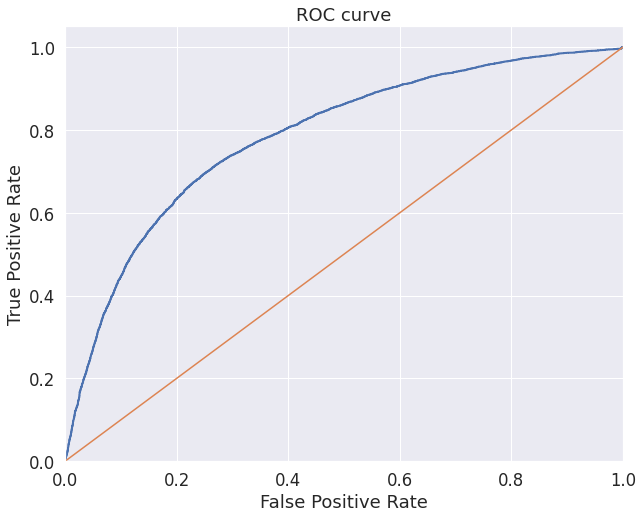

roc auc score: 0.7842066235096189
log loss score: 0.5777214203871273
Confusion matrix, without normalization
[[4854 3966]
 [1406 7274]]


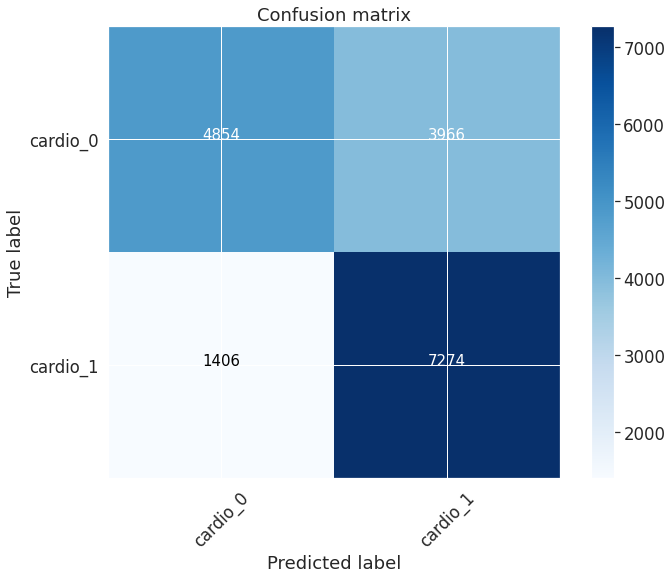

TPR 0.8380184331797235, FPR 0.4496598639455782, TNR 0.5503401360544218


In [159]:
roc_auc_sc = print_roc_auc()
TPR, FPR, TNR = print_tpr_fpr()

results = pd.DataFrame(index=np.arange(0, 3),
                       columns=['name', 'TPR', 'FPR', 'TNR', 'roc_auc_score',
                       'F-Score', 'Precision', 'Recall']) 

results.iloc[0] = ['LogisticRegression', TPR, FPR, TNR, roc_auc_sc, 
                   fscore[ix], precision[ix], recall[ix]]

False Positive Rate довольно высокий ~ 0.45.

Это означает, что 45 процентов всех пациентов получат метку 1 при том, что они на самом деле здоровы

Хорошая ли модель у нас получилась? - ответ сильно зависит от внешних факторов (какое количество FP мы можем допустить)

### Домашнее задание

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

1. https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/
2. https://en.wikipedia.org/wiki/Receiver_operating_characteristic

### RandomForestClassifier

In [ ]:
X_train.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
count,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000
mean,49817.042381,19483.557086,1.350990,164.363752,74.255214,128.752819,97.080495,1.367676,1.226248,0.088781,0.053962,0.803657
std,28842.966007,2463.552760,0.477285,8.200283,14.356398,145.930319,187.341939,0.680059,0.571030,0.284430,0.225945,0.397235
min,0.000000,10798.000000,1.000000,57.000000,10.000000,-150.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,24856.000000,17704.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000
50%,49760.000000,19706.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000
75%,74729.250000,21340.250000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,10000.000000,3.000000,3.000000,1.000000,1.000000,1.000000


In [ ]:
df[["gluc"]].value_counts()

gluc
1       59479
3        5331
2        5190
dtype: int64

In [160]:
from sklearn.ensemble import RandomForestClassifier

In [161]:
df = load_data()
X_train, X_test, y_train, y_test = get_train_test(df)
get_transformers()
feats = fit_transform(X_train)

classifier = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=11)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.774237553516249+-0.008185757096686064


In [162]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.340000, F-Score=0.720, Precision=0.639, Recall=0.824


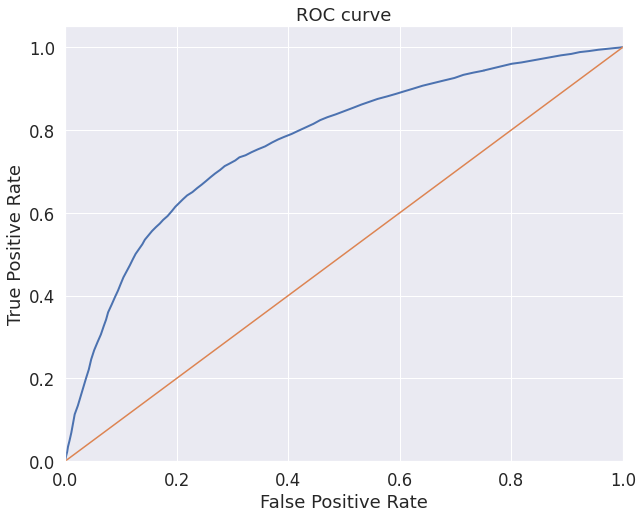

roc auc score: 0.7710797752280636
log loss score: 0.611772040442746
Confusion matrix, without normalization
[[4897 3923]
 [1611 7069]]


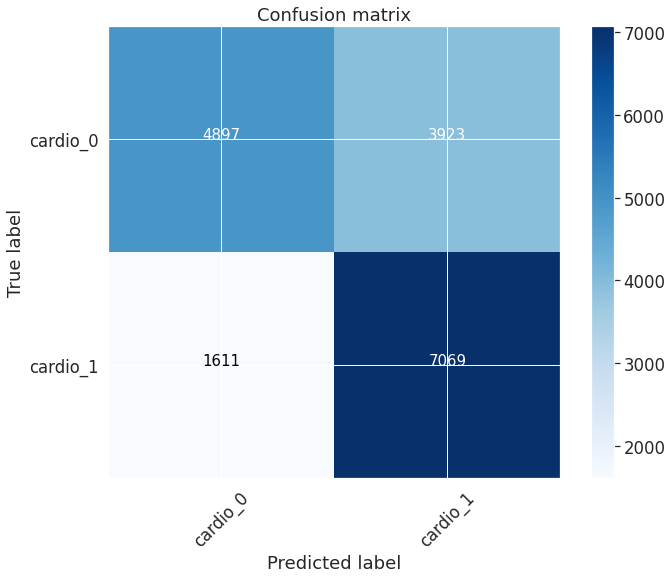

TPR 0.8144009216589861, FPR 0.4447845804988662, TNR 0.5552154195011337


In [163]:
roc_auc_sc = print_roc_auc()
TPR, FPR, TNR = print_tpr_fpr()
results.iloc[1] = ['RandomForestClassifier', TPR, FPR, TNR, roc_auc_sc, 
                   fscore[ix], precision[ix], recall[ix]]

### CatBoostClassifier

In [ ]:
%pip install catboost

     |████████████████████████████████| 67.3MB 56kB/s 


In [164]:
from catboost import CatBoostClassifier

df = load_data()
X_train, X_test, y_train, y_test = get_train_test(df)
feats = fit_transform(X_train)

frozen_params_1 = {      
     'silent':True,
     'random_state':21,
     'eval_metric':'AUC',
     'early_stopping_rounds':20
}
# 'eval_metric':'F1' AUC

frozen_params_2 = {
    'eval_metric': 'F1',
    'auto_class_weights': 'Balanced',
    'silent': True,
    'one_hot_max_size': 20,
    'early_stopping_rounds': 50,
    'boosting_type': 'Ordered',
    'allow_writing_files': False
}

classifier = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(**frozen_params_2,
    depth=8,
    iterations=300,
    learning_rate=0.5)),
])


# запустим кросс-валидацию
# cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
# cv_score = np.mean(cv_scores)
# cv_score_std = np.std(cv_scores)
# print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.396541, F-Score=0.738, Precision=0.692, Recall=0.789


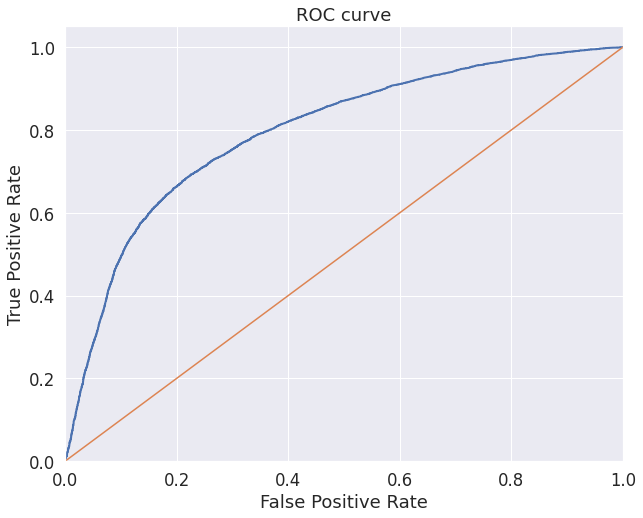

roc auc score: 0.7957081138907176
log loss score: 0.5510795478029599
Confusion matrix, without normalization
[[5773 3047]
 [1830 6850]]


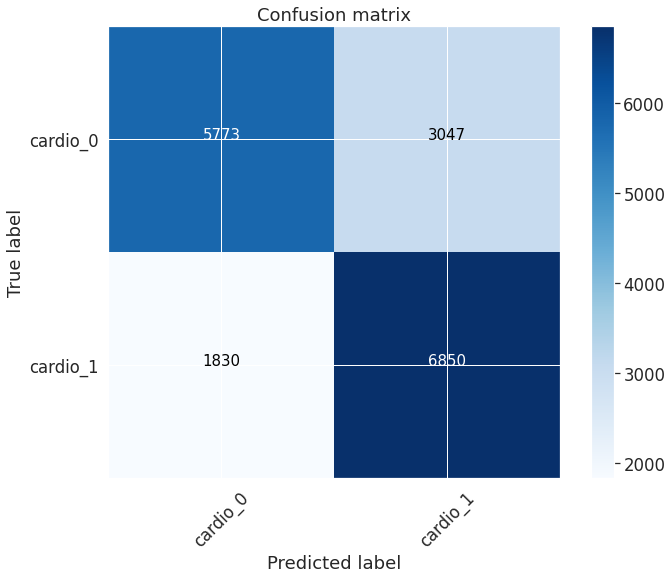

TPR 0.7891705069124424, FPR 0.34546485260770976, TNR 0.6545351473922902


In [165]:
roc_auc_sc = print_roc_auc()
TPR, FPR, TNR = print_tpr_fpr()
results.loc[2] = ['CatBoostClassifier', TPR, FPR, TNR, roc_auc_sc, 
                   fscore[ix], precision[ix], recall[ix]]


### Итоги

In [166]:
results

,name,TPR,FPR,TNR,roc_auc_score,F-Score,Precision,Recall
0,LogisticRegression,0.838018,0.44966,0.55034,0.784207,0.730385,0.647184,0.838134
1,RandomForestClassifier,0.814401,0.444785,0.555215,0.77108,0.719895,0.639306,0.823733
2,CatBoostClassifier,0.789171,0.345465,0.654535,0.795708,0.737539,0.69216,0.789286


Лучше всего с задачей справилась модель на базе CatBoostClassifier. False Positive Rate снизился до ~ 0.35.

Это означает, что 35 процентов всех пациентов получат метку 1 при том, что они на самом деле здоровы. Можно сказать что ошибка снижена на 10%.

Так же у CatBoostClassifier лучший показатель Precision, что говорит о лучшей точности предсказания модели.

В случае сильного дисбаланса классов лучше модходит метрика precision_recall_curve